# Trabalhando com Dados

Trabalhar com dados é uma arte e uma ciência. Nós falamos principalmente sobre a parte da ciência, mas nesta aula vamos ver algumas das artes.

## Explorando seus dados

Depois de identificar as perguntas que você está tentando responder e de colocar suas mãos em alguns dados, você pode se sentir tentado a mergulhar e começar imediatamente a criar modelos e obter respostas. Mas você deve resistir a esse desejo. Seu primeiro passo deve ser explorar seus dados.

## Explorando dados unidimensionais

O caso mais simples é quando você tem um conjunto de dados unidimensional, que é apenas uma coleção de números. Por exemplo, pode ser o número médio diário de minutos que cada usuário gasta em seu site, o número de vezes que cada um de uma coleção de vídeos tutoriais de ciência de dados foi assistido ou o número de páginas de cada um dos livros de ciência de dados de uma dada editora.

Um primeiro passo óbvio é calcular algumas estatísticas descritivas. Você gostaria de saber quantos pontos de dados você tem, o menor, o maior, a média e o desvio padrão. 

Mas mesmo isso não significa necessariamente um grande entendimento. Um bom próximo passo é criar um histograma, no qual você agrupa seus dados em intervalos discretos e conta quantos pontos estão em cada intervalo:

In [22]:
matplotlib inline

In [23]:
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from scipy.stats import norm
import random
import numpy.random as rnd
import math
import numpy as np
import dateutil.parser
import csv
import functools
import pandas as pd
from scipy.spatial import distance
import scipy.optimize as so
from functools import partial
# from modules.gradient_descent import maximize_batch, maximize_stochastic
from statsmodels.distributions.empirical_distribution import ECDF
# from modules.linear_algebra import shape, get_row, get_column, make_matrix, \
# vector_mean, vector_sum, dot, magnitude, vector_subtract, scalar_multiply

savefigs = False

def step(v, direction, step_size):
    """move step_size in the direction from v"""
    return [v_i + step_size * direction_i
            for v_i, direction_i in zip(v, direction)]

def safe(f):
    """return a new function that's the same as f,
    except that it outputs infinity whenever f produces an error"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            print("oops: ", args, "-", kwargs)
            return float('inf') # this means "infinity" in Python
    return safe_f

def in_random_order(data):
    """generator that returns the elements of data in random order"""
    indexes = [i for i, _ in enumerate(data)]  # create a list of indexes
    random.shuffle(indexes)                    # shuffle them
    for i in indexes:                          # return the data in that order
        yield data[i]

def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""

    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
    #step_sizes = [0.00001, 0.000001, 0.0000001, 0.00000001]

    theta = theta_0                 # set theta to initial value
    target_fn = safe(target_fn)     # safe version of target_fn
    value = target_fn(theta)        # value we're minimizing

    while True:
        gradient = gradient_fn(theta)
        print('gradient:', gradient)
        next_thetas = [step(theta, gradient, -step_size)
                       for step_size in step_sizes]
     
        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)
        print('theta and value:', next_theta, next_value)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value

def negate(f):
    """return a function that for any input x returns -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """the same when f returns a list of numbers"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn),
                          negate_all(gradient_fn),
                          theta_0,tolerance)

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.000001):

    data = list(zip(x, y))
    theta = theta_0                             # initial guess
    alpha = alpha_0                             # initial step size
    min_theta, min_value = None, float("inf")   # the minimum so far
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )
        
        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = np.subtract(theta, np.multiply(alpha, gradient_i))
            #theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn),
                               negate_all(gradient_fn),
                               x, y, theta_0, alpha_0)

In [24]:
def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)


def make_histogram(points, bucket_size):
    """buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title="", filename=None):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

Por exemplo, considere os seguintes conjuntos de dados:

In [25]:
random.seed(0)

# uniform between -100 and 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# normal distribution with mean 0, standard deviation 57
normal = [57 * norm.isf(1-random.random()) for _ in range(10000)]

Ambos possuem médias próximas a 0 e desvios-padrão próximos a 58. No entanto, eles têm distribuições muito diferentes. O histograma da distribuição do uniforme é:

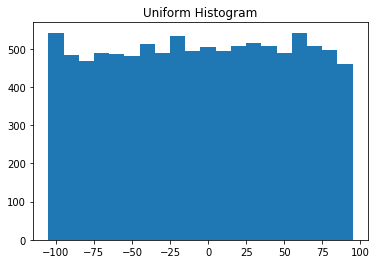

In [26]:
plot_histogram(uniform, 10, "Uniform Histogram")

Enquanto isso, o histograma da distribuição normal é:

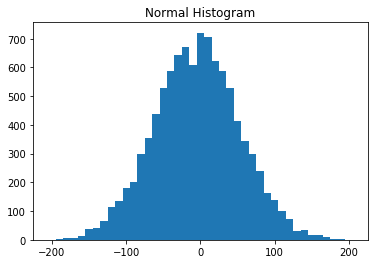

In [27]:
plot_histogram(normal, 10, "Normal Histogram")

Nesse caso, as duas distribuições têm um máximo e um mínimo bem diferentes, mas mesmo sabendo disso não basta para entender como elas se distinguem.

**Observação:** o código acima serve muito bem para fins didáticos, mas no seu dia-a-dia você deve se acostumar a usar funções prontas:

In [28]:
# uniform between -100 and 100
uniform_sample = rnd.uniform(-100, 100, 10000);

# normal distribution with mean 0, standard deviation 57
normal_sample = rnd.normal(0, 57, 10000);

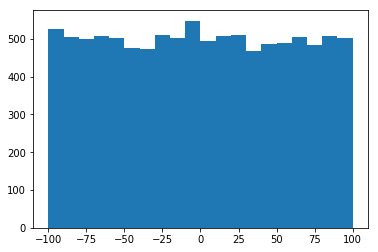

In [29]:
fig = plt.figure()
plt.hist(uniform_sample, bins=20);
# if savefigs:
#     fig.savefig('aula09-uniform_hist.png')

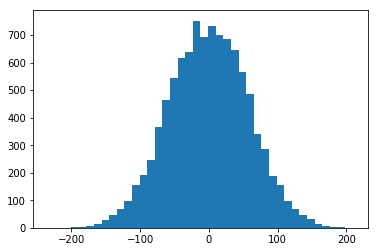

In [30]:
fig = plt.figure()
plt.hist(normal_sample, bins=40);
# if savefigs:
#     fig.savefig('aula09-nromal_hist.png')

Histogramas não são as únicas formas de visualizar como os dados estão distribuídos, até mesmo porque eles podem ser enganosos. Você pode usar a CDF:

In [31]:
def plotECDF(data, scale_x="linear", scale_y="linear", filename=None):
    ecdf = ECDF(data)
    x, y = ecdf.x, ecdf.y
    fig = plt.figure()
    plt.plot(x, y, 'o-')
    plt.ylabel("Pr(X $\leq$ x)")
    plt.xlabel("x")
    plt.xscale(scale_x)
    plt.yscale(scale_y)    
    plt.show()
    if filename:
        fig.savefig(filename, dpi=150)
    

Ou a CCDF:

In [32]:
def plotECCDF(data, scale_x="linear", scale_y="linear", filename=None):
    ecdf = ECDF(data)
    x, y = ecdf.x, 1-ecdf.y
    fig = plt.figure()    
    plt.plot(x, y, 'o-')
    plt.ylabel("Pr(X > x)")
    plt.xlabel("x")
    plt.xscale(scale_x)
    plt.yscale(scale_y)
    plt.show()
    if filename:
        fig.savefig(filename, dpi=150)
    

Ou a função *Odds Ratio*, que é igual a:

$$OR(x) = \frac{CDF(x)}{CCDF(x)} = \frac{CDF(x)}{1-CDF(x)}$$

In [33]:
def plotEOR(data, scale_x="linear", scale_y="linear", filename=None):
    ecdf = ECDF(data)
    x, y = ecdf.x[:-1], ecdf.y[:-1]   
    y = y/(1-y)
    fig = plt.figure()     
    plt.plot(x, y, 'o-')
    plt.ylabel("Odds Ratio")
    plt.xlabel("x")
    plt.xscale(scale_x)
    plt.yscale(scale_y)
    plt.show()
    if filename:
        fig.savefig(filename, dpi=150)    
    

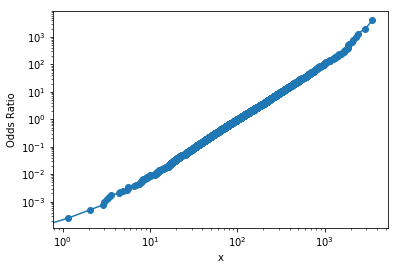

In [34]:
from scipy.stats import fisk
c = 3.09
#lld = fisk.rvs(c, size=1000)
lld = fisk.rvs(2, loc=0, scale=100, size=4000, random_state=None)
plotEOR(lld, "log", "log")

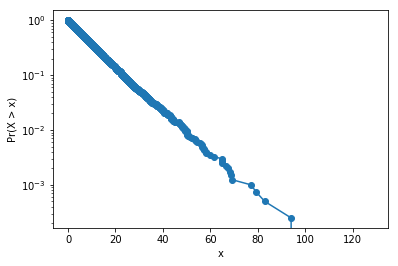

In [35]:
ed = np.random.exponential(10,4000)
plotECCDF(ed, "linear", "log")

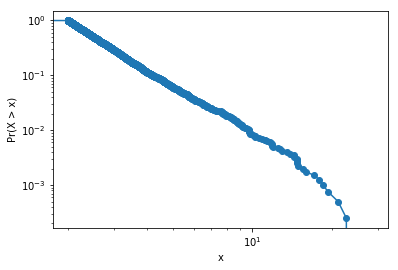

In [36]:
a, m = 3., 2.  # shape and mode
pd = (np.random.pareto(a, 4000) + 1) * m
plotECCDF(pd, "log", "log")

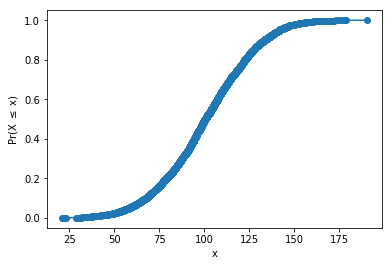

In [37]:
nd = np.random.normal(100, 25, 4000)
plotECDF(nd, "linear", "linear")

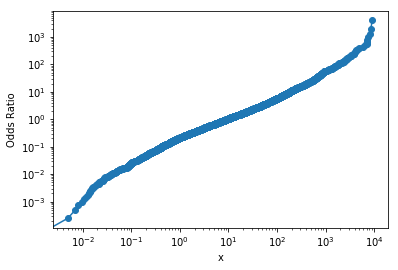

In [38]:
mu, sigma = np.log10(np.mean(lld)), np.log10(np.std(lld)) # mean and standard deviation
lnd = np.random.lognormal(mu, sigma, 4000)
plotEOR(lnd, "log", "log")

In [39]:
import pandas as pd
df = pd.read_table('./data/metatalk/meta/15547.dat', header=None, dtype=int)
df

FileNotFoundError: File b'./data/metatalk/meta/15547.dat' does not exist

In [ ]:
data = df.values
data = np.reshape(data, len(data))
print(data.shape)
print(np.mean(data))
plotEOR(data, "log", "log")

## Duas Dimensões

Agora imagine que você tenha um conjunto de dados com duas dimensões. Talvez, além dos minutos diários, você tenha anos de experiência em ciência de dados. Claro que você gostaria de entender cada dimensão individualmente. Mas você provavelmente também quer espalhar os dados e ver como as dimensões se relacionam.

Por exemplo, considere outro conjunto de dados falso:

In [ ]:
def random_normal():
    """returns a random draw from a standard normal distribution"""
    return norm.isf(1-random.random())
    #return inverse_normal_cdf(random.random())


xs = [random_normal() for _ in range(1000)]
#para cada valor de xs, vamos gerar um valor distribuido normalmente com localidade opostas
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

Se você plotar o histograma de `ys1` e `ys2`, teria gráficos de aparência muito parecidos (na verdade, ambos são normalmente distribuídos com a mesma média e desvio padrão).

In [ ]:
fig = plt.figure()

plt.subplot(1, 2, 1) # (rows, columns, panel number)
plt.hist(ys1, 10)
plt.title("ys1")
plt.subplot(1, 2, 2) # (rows, columns, panel number)
plt.title("ys2")
plt.hist(ys2, 10)

#fig, ax = plt.subplots(1, 2)
#ax[0].hist(ys1, 20)
#ax[0].title('ys1')
#ax[1].hist(ys2, 20)
plt.show()
if savefigs:
    fig.savefig('aula09-twohists.png')

Mas cada um tem uma distribuição conjunta muito diferente com `xs`, como pode ser visto a seguir:

In [ ]:
fig = plt.figure()
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray', label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Very Different Joint Distributions")
plt.show()

if savefigs:
    fig.savefig('aula09-scatter.png')

A diferença também seria clara se você calcular as correlações:

In [ ]:
from numpy import corrcoef as correlation

print(correlation(xs, ys1)[1,0])
print(correlation(xs, ys2)[1,0])

## Muitas dimensões

Com muitas dimensões, você gostaria de saber como todas as dimensões se relacionam umas com as outras. Uma abordagem simples é examinar a matriz de correlação, na qual a entrada na linha `i` e coluna `j` é a correlação entre a dimensão `i` e a dimensão `j` dos dados. Essa foi a razão pela qual usamos os índices `[1,0]` no código anterior, pois a função `corrcoef` do `numpy` já retorna a matriz de correlação de um conjunto de dados com muitas dimensões:

In [ ]:
#um vetor de valores normalmente distribuidos e sem correlacao com os demais
xsrnd = [random_normal() for _ in range(1000)]

#cria uma matriz em que cada linha contem um dos vetores
data = np.stack((xsrnd,xs,ys1,ys2))

print(correlation(data))

Uma abordagem mais visual (se você não tiver muitas dimensões) é criar uma matriz de gráficos de dispersão mostrando todos os gráficos de dispersão em pares. Para isso, usaremos `plt.subplots()`, que nos permite criar *sub-gráficos* em nosso gráfico. Damos a ele o número de linhas e o número de colunas, e ele retorna um objeto de figura (que não usaremos) e uma matriz bidimensional de objetos de eixos (que nós plotaremos):

In [ ]:
def make_scatterplot_matrix(data):

    #_, num_columns = shape(data)
    _, num_columns = data.shape
    
    fig, ax = plt.subplots(num_columns, num_columns)

    for i in range(num_columns):
        for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
            #if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))
            if i != j: ax[i][j].scatter(data[:,j], data[:,i])

            # unless i == j, in which case show the series name
            else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                    xycoords='axes fraction',
                                    ha="center", va="center")

            # then hide axis labels except left and bottom charts
            if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
            if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][1].get_ylim())
    if savefigs:
        fig.savefig('aula09-multiscatter.png')

plt.show()


Agora, vamos gerar alguns dados aleatórios:

In [ ]:
# first, generate some random data

num_points = 100

def random_row():
    row = [None, None, None, None]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
    return row

random.seed(0)
data = [random_row()
        for _ in range(num_points)]

#vamos usar numpy, muito mais facil!
data = np.array(data)

Agora, podemos plotar os gráficos de dispersão:

In [ ]:
make_scatterplot_matrix(data)

Olhando para os gráficos de dispersão, você pode ver que a série 1 é muito negativamente correlacionada com a série 0, a série 2 é positivamente correlacionada com a série 1, e a série 3 assume apenas os valores 0 e 6, com 0 correspondendo a pequenos valores da série 2 e 6 correspondendo a grandes valores.

Essa é uma maneira rápida de ter uma noção aproximada de quais de suas variáveis estão correlacionadas (a menos que você gaste horas ajustando o `matplotlib` para exibir as coisas exatamente da maneira que você quer, o que pode ser um desperdício de horas de trabalho).

## Limpeza e Formatação

Dados do mundo real estão sujos. Muitas vezes você terá que fazer algum trabalho antes de poder usá-los. Vimos exemplos disso nas aulas passadas. Precisamos converter *strings* em *floats* ou *ints* antes de usá-las. Anteriormente, fizemos isso antes de usar os dados:

`closing_price = float(row[2])`

No entanto, provavelmente estamos menos propensos se fizermos a análise (ou *parser*) dos dados antes de manipulá-los, o que podemos fazer criando uma função que envolva o `csv.reader`. Vamos dar uma lista de analisadores (*parsers*), cada um especificando como analisar uma das colunas. E nós usaremos `None` para representar "não faça nada a esta coluna":

In [ ]:
def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
    apply the appropriate one to each element of the input_row"""
    
    return [parser(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """wrap a reader to apply the parsers to each of its rows"""
    
    for row in reader:
        yield parse_row(row, parsers)

E se houver dados incorretos? Um valor "float" que na verdade não representa um número? Normalmente, preferimos ter um `None` do que travar nosso programa. Podemos fazer isso com uma função auxiliar:

In [ ]:
def try_or_none(f):
    """wraps f to return None if f raises an exception
    assumes f takes only one input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

Depois podemos reescrever a função `parse_row` para usá-la:

In [ ]:
def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value 
            for value, parser in zip(input_row, parsers)]

Por exemplo, se tivermos [preços de ações](https://www.dropbox.com/s/ipqg7m12gsx8ot2/comma_delimited_stock_prices.csv?dl=0) delimitados por vírgulas com dados inválidos:

`6/20/2014,AAPL,90.91
6/20/2014,MSFT,41.68
6/20/3014,FB,64.5
6/19/2014,AAPL,91.86
6/19/2014,MSFT,n/a
6/19/2014,FB,64.34`

A gente pode ler e processar os dados em um passo único:

In [ ]:
data = []

with open("./data/comma_delimited_stock_prices.csv", "r") as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)

E depois, a gente apenas precisa verificar se existem linhas com `None`

In [ ]:
for row in data:
    if any(x is None for x in row):
        print(row)

e decidir o que queremos fazer com elas. Em geral, as três opções são:

* livrar-se delas
* voltar à fonte e tentar corrigir os dados errados/ausentes
* não fazer nada e cruzar os dedos.

Poderíamos criar ajudantes semelhantes para o `csv.DictReader`. Nesse caso, você provavelmente desejaria fornecer um `dict` de *parsers* por nome do campo. Por exemplo:

In [ ]:
def try_parse_field(field_name, value, parser_dict):
    """try to parse value using the appropriate function from parser_dict"""
    parser = parser_dict.get(field_name) # None if no such entry
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value

def parse_dict(input_dict, parser_dict):
    return { field_name : try_parse_field(field_name, value, parser_dict)
            for field_name, value in input_dict.items() }

In [ ]:
import pandas as pd
df = pd.read_csv("./data/nba_players_season_stats.csv")
df

A função `parse_dict` processa o dicionário criado a partir de uma linha do arquivo `csv` usando o dicionário de *parsers* que você deve criar. Para cada campo problemático, ou seja, que merece o seu próprio *parser*, a função `try_parse_field` executa o *parser* correspondente.

Por exemplo, ao processar o arquivo [`./data/nba_players_season_stats.csv`](https://www.dropbox.com/s/tkgxwud89ygx7dv/nba_players_season_stats.csv?dl=0), que contém informações históricas sobre o desempenho de jogadores da NBA, verificamos que há nomes com um caractere `*` ao seu final e posições múltiplas no campo `Pos`, como as posições `F-C` (ala e pivô, ou *forward* e *center*) e `G-F` (armador e ala, ou *guard* e *forward*). Decidimos tratar essas duas situações da seguinte forma:

1) No caso do nome, vamos usar a função `parse_name` para simplesmente remover o `*` do nome:

In [ ]:
def parse_name(name):
    if name[-1] == '*':
        return name[:-1]
    else:
        return name

2) No caso das posições, converteremos `F-C` para `PF` (ala de força, ou *power forward*, que é uma posição que achamos adequada para esse jogador) e `G-F` para `SF` (ala pequeno, ou *small forward*, que também consideramos uma posição adequada para o jogador que joga nessas duas posições). Assim, criamos a função `parse_pos` para tratar esses dois casos:

In [ ]:
def parse_pos(pos):
    if pos == 'F-C':
        return 'PF'
    elif pos == 'G-F':
        return 'SF'
    else:
        return pos
    

Agora podemos criar o nosso dicionário de *parsers*

In [ ]:
parser_nba_player = dict()
parser_nba_player['Pos'] = parse_pos
parser_nba_player['Player'] = parse_name

e processar o arquivo com ele:

In [ ]:
input_file = csv.DictReader(open("./data/nba_players_season_stats.csv"))
data = []
id_row = 0
for row in input_file:
    parsed_row = parse_dict(row, parser_nba_player)
    data.append(parsed_row)
    if id_row == 71:
        print("Uma linha com os dois problemas:")
        print(row) 
    id_row = id_row + 1

Ao processar o arquivo, eu imprimi uma linha problemática, a linha `71`. Para verificar se o *parser* funcionou corretamente, vamos imprimir a mesma linha, só que agora nos dados tratados, que estão em `data`:

In [ ]:
print("Problema resolvido:")
print(data[71])

Um bom próximo passo é verificar se há valores discrepantes (*outliers*), usando técnicas vistas anteriormente neste curso, ou investigando de forma *ad hoc*. Por exemplo, você notou que uma das datas no arquivo de ações tinha o ano 3014? Isso não lhe dará (necessariamente) um erro, mas está completamente errado, e você obterá resultados malucos se não consertar. Conjuntos de dados do mundo real têm pontos decimais ausentes, zeros extras, erros tipográficos e inúmeros outros problemas que você deve capturar. (Talvez não seja oficialmente seu trabalho, mas quem mais vai fazer isso?)

## Manipulando Dados

Uma das habilidades mais importantes de um cientista de dados é manipular dados. É mais uma abordagem geral do que uma técnica específica, por isso vamos trabalhar apenas com alguns exemplos para lhe dar o sabor disso.

Imagine que estamos trabalhando com `dict`s de preços de ações que se parecem com:

```
data = [
{'closing_price': 102.06,
'date': datetime.datetime(2014, 8, 29, 0, 0),
'symbol': 'AAPL'},
# ...
]
```
Conceitualmente, pensamos neles como linhas (como em uma planilha).

Na aula passada, foi pedido que você criasse um arquivo `historical_prices.csv`, contendo o histórico de preços de algumas ações. Vamos usar esse arquivo a partir de agora. Se você não tem esse arquivo, pode baixar o meu [aqui](https://www.dropbox.com/s/eofdd0t0x9kyhhz/historical_prices.csv?dl=0). Então, vamos carregar esse arquivo como uma lista de dicionários, fazendo o *parse* de cada campo de acordo com o seu valor:

In [ ]:
def parse_float(price):
    return float(price)

def parse_date(date):
    return dateutil.parser.parse(date)

In [ ]:
parser_hprices = dict()
parser_hprices['opening_price'] = parse_float
parser_hprices['high_price'] = parse_float
parser_hprices['low_price'] = parse_float
parser_hprices['closing_price'] = parse_float
parser_hprices['adj_close'] = parse_float
parser_hprices['volume'] = parse_float
parser_hprices['date'] = parse_date
input_file = csv.DictReader(open("./data/historical_prices.csv"))
data = []
for row in input_file:
    parsed_row = parse_dict(row, parser_hprices)
    data.append(parsed_row)

In [ ]:
print(data[0]['closing_price']/data[0]['opening_price'])

Vamos começar a fazer perguntas sobre esses dados. Ao longo do caminho, tentaremos perceber padrões no que estamos fazendo e abstrair algumas ferramentas para facilitar a manipulação dos dados.

Por exemplo, suponha que queremos saber o preço de fechamento mais alto para a AAPL. Vamos dividir isso em etapas concretas:

1. Restringir-nos às linhas AAPL.

2. Pegamos o `closing_price` de cada linha.

3. Tiramos o máximo desses preços.

Podemos fazer todos os três ao mesmo tempo usando uma compreensão de lista:

In [ ]:
max_aapl_price = max(row["closing_price"]
                     for row in data
                     if row["symbol"] == "AAPL")

print("Maior preço da ação AAPL: ", max_aapl_price)

Mais genericamente, podemos querer saber o preço de fechamento mais alto de todos os estoques em nosso conjunto de dados. Uma maneira de fazer isso é:
1. Agrupe todas as linhas com o mesmo símbolo.
2. Dentro de cada grupo, faça o mesmo que antes:

In [ ]:
# group rows by symbol
by_symbol = defaultdict(list)
for row in data:
    by_symbol[row["symbol"]].append(row)

        
# use a dict comprehension to find the max for each symbol
max_price_by_symbol = { symbol : max(row["closing_price"]
                                     for row in grouped_rows)
                       for symbol, grouped_rows in by_symbol.items() }

In [ ]:
print(max_price_by_symbol)

Existem alguns padrões aqui já. Nos dois exemplos, precisávamos extrair o valor de `closing_price` de cada `dict`. Então, vamos criar uma função para escolher um campo fora de um `dict` e outra função para extrair o mesmo campo de uma coleção de `dict`s:

In [ ]:
def picker(field_name):
    """returns a function that picks a field out of a dict"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)

Vamos testar a função `picker`:

In [ ]:
first_row = data[0]
picksymbol = picker("symbol")
print(picksymbol(first_row))

Agora vamos testar a função `pluck`:

In [ ]:
all_dates = set(pluck("date", data))
sorted_dates = sorted(list(all_dates))
print(sorted_dates)

In [ ]:
all_closing_prices = list(pluck("closing_price", data))
sorted_closing_prices = sorted((all_closing_prices), reverse=True)
print(sorted_closing_prices[:5])

Agora vamos criar uma função para agrupar linhas pelo resultado de uma função agrupadora (*grouper*) e, opcionalmente, aplicar algum tipo de transformador de valor (`value_transform`) a cada grupo:

In [ ]:
def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
    if value_transform is None:
        return grouped
    else:
        return { key : value_transform(rows)
                for key, rows in grouped.items() }

Isso nos permite reescrever nossos exemplos anteriores de forma bastante simples. Por exemplo:

In [ ]:
max_price_by_symbol = group_by(picker("symbol"),
                               data,
                               lambda rows: max(pluck("closing_price", rows)))

print(max_price_by_symbol)

Agora podemos começar a fazer perguntas mais complicadas, como quais são as maiores e menores alterações percentuais de um dia em nosso conjunto de dados. A alteração percentual é `price_today / price_yesterday - 1`, o que significa que precisamos de alguma forma de associar o preço de hoje e o preço de ontem. Uma abordagem é agrupar os preços por símbolo e, em seguida, dentro de cada grupo:
1. Ordene os preços por data.
2. Use `zip` para obter pares (anterior, atual).
3. Transforme os pares em novas linhas de “alteração percentual”.

Começaremos escrevendo uma função para fazer todo o trabalho dentro de cada grupo:

In [ ]:
def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    # zip with an offset to get pairs of consecutive days
    return [{ "symbol" : today["symbol"],
              "date" : today["date"],
              "change" : percent_price_change(yesterday, today) }
             for yesterday, today in zip(ordered, ordered[1:])]


Depois, vamos apenas usar isso como o `value_transform` em um `group_by`:

In [ ]:
# key is symbol, value is list of "change" dicts
changes_by_symbol = group_by(picker("symbol"), data, day_over_day_changes)

# collect all "change" dicts into one big list
all_changes = [change 
               for changes in changes_by_symbol.values()
               for change in changes]

Neste ponto, é fácil encontrar o maior e o menor valor:

In [ ]:
max_change = max(all_changes, key=picker("change"))
print(max_change)

Agora podemos usar esse novo conjunto de dados `all_changes` para descobrir qual mês é o melhor para investir em ações de tecnologia. Primeiro agrupamos as mudanças por mês; então calculamos a mudança geral dentro de cada grupo.

Mais uma vez, escrevemos uma `value_transform` apropriada e, depois, usamos `group_by`:

In [ ]:
# to combine percent changes, we add 1 to each, multiply them, and subtract 1
# for instance, if we combine +10% and -20%, the overall change is
# (1 + 10%) * (1 - 20%) - 1 = 1.1 * .8 - 1 = 0.88 - 1 = -12%
def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return functools.reduce(combine_pct_changes, pluck("change", changes))

overall_change_by_month = group_by(lambda row: row['date'].month,
                                   all_changes,
                                   overall_change)
print(overall_change_by_month)

Iremos usar muito esses tipos de manipulação ao longo do curso, então você precisa entender muito bem o que foi ensinado até aqui.

## Redimensionamento

Muitas técnicas são sensíveis à escala dos seus dados. Por exemplo, imagine que você tenha um conjunto de dados que consiste nas alturas e pesos de centenas de pessoas e que você está tentando identificar grupos de tamanhos corporais.

Intuitivamente, gostaríamos que os clusters representassem pontos próximos uns dos outros, o que significa que precisamos de alguma noção de distância entre os pontos. Nós já temos uma função de distância euclidiana, então uma abordagem natural pode ser tratar pares (altura, peso) como pontos no espaço bidimensional. Considere as [pessoas](https://www.dropbox.com/s/9g7nuca3ednouk0/sample_people_ht_wt.csv?dl=0) listadas abaixo:

In [ ]:
df = pd.read_csv('data/sample_people_ht_wt.csv')
df

Aqui estamos usando a biblioteca `pandas` para carregar um csv e o exibir em um formato amigável. Para converter os dados que carregou, que estão em formato `DataFrame` para uma lista de vetores `numpy`, faça:

In [ ]:
people = df.values
print(people)

Para essas pessoas, se a gente medir as alturas em polegadas (*inches*), então a pessoa mais similar de `B` é `A`:

In [ ]:
def dadosPessoa(people, idx,alturaidx=1):
    return [people[idx][alturaidx],people[idx][3]]

print("B para A:", distance.euclidean(dadosPessoa(people,1),dadosPessoa(people,0)))
print("B para C:", distance.euclidean(dadosPessoa(people,1),dadosPessoa(people,2)))

No entanto, se medirmos a altura em centímetros, então a pessoa mais parecida com B passa a ser C:

In [ ]:
print("B para A:", distance.euclidean(dadosPessoa(people,1,2),dadosPessoa(people,0,2)))
print("B para C:", distance.euclidean(dadosPessoa(people,1,2),dadosPessoa(people,2,2)))

Obviamente, é problemático se as unidades de medida puderem alterar resultados como este. Por esse motivo, quando as dimensões não são comparáveis entre si, às vezes redimensionamos nossos dados para que cada dimensão tenha média 0 e desvio padrão 1. Isso efetivamente elimina as unidades, convertendo cada dimensão em "desvios-padrão da média".

Para começar, precisamos calcular a média e o desvio padrão para cada coluna:

In [ ]:
def scale(data_matrix):
    num_rows, num_cols = data_matrix.shape
    means = [np.mean(data_matrix[:,j])
             for j in range(num_cols)]
    stdevs = [np.std(data_matrix[:,j])
              for j in range(num_cols)]
    return means, stdevs

Depois, usamos esse método para criar uma nova matriz de dados:

In [ ]:
def rescale(data_matrix):
    """rescales the input data so that each column
    has mean 0 and standard deviation 1
    ignores columns with no deviation"""
    means, stdevs = scale(data_matrix)


    num_rows, num_cols = data_matrix.shape

    for i in range(0,num_cols):
        if stdevs[i] > 0:
            data_matrix[:,i] = (data_matrix[:,i] - means[i]) / stdevs[i]


    return data_matrix

In [ ]:
data_people = rescale(people[:,1:4])
rescaled_people = people
rescaled_people[:,1:4] = data_people
print(rescaled_people)

Agora podemos verificar que pessoa é de fato a mais próxima de B:

In [ ]:
print("Usando a coluna 1 (polegadas) redimensionada:")
print("B para A:", distance.euclidean(dadosPessoa(rescaled_people,1),dadosPessoa(rescaled_people,0)))
print("B para C:", distance.euclidean(dadosPessoa(rescaled_people,1),dadosPessoa(rescaled_people,2)))

print("Usando a coluna 2 (centímetros) redimensionada:")
print("B para A:", distance.euclidean(dadosPessoa(rescaled_people,1,2),dadosPessoa(rescaled_people,0,2)))
print("B para C:", distance.euclidean(dadosPessoa(rescaled_people,1,2),dadosPessoa(rescaled_people,2,2)))


Como sempre, você precisa usar seu julgamento. Se você pegasse um enorme conjunto de dados de alturas e pesos e filtrasse as pessoas com alturas entre 69,5 e 70,5 polegadas, é bastante provável (dependendo da pergunta que você está tentando responder) que a variação restante seja bem menor, e você pode não querer colocar seu desvio padrão em pé de igualdade com os desvios de outras dimensões.

## Redução de dimensionalidade

Às vezes, as dimensões "reais" (ou úteis) dos dados podem não corresponder às dimensões que temos. Por exemplo, vamos carregar as alturas e os pesos de uma coleção de [jogadores da NBA](https://www.dropbox.com/s/yyxr30xpr6o0hk4/nba_ht_wt.csv?dl=0):

In [ ]:
parser_people = dict()
parser_people['Height'] = parse_float
parser_people['Weight'] = parse_float
parser_people['Age'] = int #poderiamos usar apenas float para as Height and Weight
input_file = csv.DictReader(open("./data/nba_ht_wt.csv"))
data = []
for row in input_file:
    parsed_row = parse_dict(row, parser_people)
    data.append(parsed_row)

In [ ]:
data[0]

Vamos ver como a relação de peso e altura dos jogadores:

In [ ]:
alturas = list(pluck("Height", data))
pesos = list(pluck("Weight", data))
names = list(pluck("Player", data))

print(names[0], pesos[0], alturas[0])

fig = plt.figure()
plt.scatter(alturas, pesos)
plt.title("Altura vs. Peso de jogadores da NBA")
plt.xlabel("Altura (polegadas)")
plt.ylabel("Peso (libras)")
plt.show()

if savefigs:
    fig.savefig('aula09-pesoaltura-nba.png')

A maior parte da variação nos dados parece estar ao longo de uma única dimensão que não corresponde ao eixo x ou ao eixo y.

Quando esse é o caso, podemos usar uma técnica chamada análise de componente principal (*principal component analysis*, ou PCA) para extrair uma ou mais dimensões que capturam o máximo possível da variação nos dados.

Na prática, você não usaria essa técnica em um conjunto de dados com tão poucas dimensões. A redução de dimensionalidade é mais útil quando seu conjunto de dados tem um grande número de dimensões e você deseja encontrar um pequeno subconjunto que capture a maior parte da variação. 

Como primeiro passo, precisamos traduzir os dados para que cada dimensão tenha média zero:

In [40]:
def de_mean_matrix(A):
    """returns the result of subtracting from every value in A the mean
    value of its column. the resulting matrix has mean 0 in every column"""
    num_rows, num_cols = A.shape
    dA = np.zeros(A.shape)
    for i in range(0,num_cols):
        dA[:,i] = A[:,i] - np.mean(A[:,i])
    return dA

In [ ]:
data_matrix = np.transpose(np.stack((alturas, pesos)))
d_data_matrix = de_mean_matrix(data_matrix)

print("antes: ", data_matrix[0])
print("depois: ", d_data_matrix[0])

Se não fizermos isso, nossas técnicas provavelmente identificarão a média em si e não a variação nos dados. A partir de agora chamaremos de matriz *de-meaned* uma matriz que teve as suas colunas subtraídas de suas médias.

Abaixo vemos os dados do exemplo após o subtrair a média:

In [ ]:
fig = plt.figure()
plt.scatter(d_data_matrix[:,0], d_data_matrix[:,1])
plt.title("Altura vs. Peso depois de subtrair a média")
plt.xlabel("Altura (polegadas) - média")
plt.ylabel("Peso (libras) - média")
plt.show()
if savefigs:
    fig.savefig('aula09-demeaned-nba.png')

Agora, dada uma matriz *de-meaned* X, podemos perguntar qual é a direção que captura a maior variação nos dados.

Especificamente, dada uma direção $d$ (um vetor de magnitude $1$), cada linha $x$ na matriz estende `dot(x, d)` na direção $d$. E cada vetor não-zero $w$ determina uma direção se o reescalonarmos para ter magnitude $1$:

In [ ]:
def direction(w):
    mag = np.linalg.norm(w)
    return [w_i / mag for w_i in w]

Portanto, dado um vetor diferente de zero $w$, podemos calcular a variância de nosso conjunto de dados na direção determinada por $w$:

In [ ]:
def directional_variance_i(x_i, w):
    """the variance of the row x_i in the direction w"""
    return np.dot(x_i, direction(w)) ** 2

def directional_variance(X, w):
    """the variance of the data in the direction w"""
    return sum(directional_variance_i(x_i, w) for x_i in X)

Ou, para cada linha $\mathbf{x_i} = \{\mathbf{x_1}, \cdots, \mathbf{x_n}\}$ dos nossos dados de dimensão $m$:

$\mathcal{V} = \sum_i^n{(\mathbf{x_i} \cdot \mathbf{w})^2 } = \sum_i^n{(x_{i1}\times w_1 + \cdots + x_{im}\times w_m)^2 }$

Gostaríamos de encontrar a direção $w$ que maximiza essa variação. Então, dado um $w_0$ inicial, para onde devemos mover $w_0$ para que a variação aumente? Podemos fazer isso usando gradiente descendente, assim que tivermos a função gradiente, que calcula onde a variância aumenta mais para cada uma das $m$ dimensões:

$\nabla \mathcal{V} = \sum_i^n{[2(\mathbf{x_i} \cdot \mathbf{w})x_{i1}~\mathbf{e_{w_1}} + \cdots + 2(\mathbf{x_i} \cdot \mathbf{w})x_{im}~\mathbf{e_{w_m}}]}$

In [ ]:
def directional_variance_gradient_i(x_i, w):
    """the contribution of row x_i to the gradient of
    the direction-w variance"""
    projection_length = np.dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    ncols = len(w)
    g = np.array([directional_variance_gradient_i(x_i,w) for x_i in X])
    s = [sum(g[:,i]) for i in range(ncols)]
    return s
    #return vector_sum(directional_variance_gradient_i(x_i,w) for x_i in X)

O primeiro componente principal é apenas a direção que maximiza a função `directional_variance`:

In [ ]:
def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X),          
        partial(directional_variance_gradient, X), 
        guess)
    return direction(unscaled_maximizer)

Ou você pode também usar o método *gradiente descendente estocástico*:

In [ ]:
def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x, w),
        lambda x, _, w: directional_variance_gradient_i(x, w),
        X, [None for _ in X], guess)
    return direction(unscaled_maximizer)

Observe abaixo que a direção $w$ que maximiza a variância nesse caso é o vetor `[0.106, 0.994]`, que parece capturar o eixo principal no qual nossos dados variam:

In [ ]:
PC1 = first_principal_component_sgd(d_data_matrix)
print("componente principal: ", PC1)

fig = plt.figure()
ax = plt.axes()
plt.scatter(d_data_matrix[:,0], d_data_matrix[:,1])
plt.title("Primeiro componente principal")
plt.xlabel("Altura (polegadas) - média")
plt.ylabel("Peso (libras) - média")



ax.arrow(0, 0, *np.dot(PC1,20), head_width=1, head_length=2, color='r')

plt.show()
if savefigs:
    fig.savefig('aula09-demeaned-nba2.png')

Uma vez que encontramos a direção que representa o primeiro componente principal, a gente pode projetá-la nos nossos dados para encontrar os valores dos mesmos nesse componente:

In [ ]:
def project(v, w):
    """return the projection of v onto w"""
    coefficient = np.dot(v, w)
    return np.dot(coefficient, w)

Se quisermos encontrar outros componentes, primeiro teremos que remover as projeções dos dados:

In [ ]:
def remove_projection_from_vector(v, w):
    """projects v onto w and subtracts the result from v"""
    return v - project(v, w)

def remove_projection(X, w):
    """for each row of X
    projects the row onto w, and subtracts the result from the row"""
    return [remove_projection_from_vector(x_i, w) for x_i in X]

Como neste exemplo o conjunto de dados é apenas bidimensional, depois de removermos o primeiro componente, o que resta será efetivamente unidimensional: 

In [ ]:
new_data_matrix = np.array(remove_projection(d_data_matrix, PC1))

fig = plt.figure()
ax = plt.axes()
plt.scatter(new_data_matrix[:,0], new_data_matrix[:,1])
plt.title("Os dados depois de removermos o primeiro componente principal")
ax.arrow(0, 0, *np.dot(PC1,3), head_width=0.2, head_length=0.5, color='r')
plt.axis("equal")
plt.show()
if savefigs:
    fig.savefig('aula09-pca-nba1.png', dpi=150)

**Observação importante:** usamos o comando `plt.axis("equal")` para fazer com que o espaçamento seja idêntico entre as unidades de ambos os eixos. Apenas assim conseguimos visualizar que o primeiro componente principal, representado pela seta vermelha, é ortogonal ao restante dos dados. Isso faz sentido, uma vez que "removemos" essa dimensão dos dados restantes.

Nesse ponto, podemos encontrar o próximo componente principal repetindo o processo no resultado de `remove_projection`. Melhor que isso, pode generalizar o processo para um conjunto de dados dimensionais maiores, encontrando iterativamente quantos componentes desejarmos:

In [ ]:
def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        print(component)
        components.append(component)
        X = remove_projection(X, component)

    return components

In [ ]:
PCS = principal_component_analysis(d_data_matrix, 2)

In [ ]:
fig = plt.figure()
ax = plt.axes()
plt.scatter(d_data_matrix[:,0], d_data_matrix[:,1])
plt.title("Componentes Principais")
plt.xlabel("Altura (polegadas) - média")
plt.ylabel("Peso (libras) - média")

ax.arrow(0, 0, *np.dot(PCS[0],20), head_width=1, head_length=2, color='r')
ax.arrow(0, 0, *np.dot(PCS[1],2), head_width=4, head_length=0.5, color='r')
#plt.axis('equal') #rode novamente com essa linha

plt.show()
if savefigs:
    fig.savefig('aula09-pca-nba2.png', dpi=150)

Essa técnica é valiosa por alguns motivos. Primeiro, pode nos ajudar a limpar nossos dados, eliminando as dimensões de ruído e consolidando as dimensões altamente correlacionadas.

Em segundo lugar, depois de extrair uma representação de baixa dimensão de nossos dados, podemos usar uma variedade de técnicas que não funcionam tão bem em dados de alta dimensão. Vamos ver exemplos de tais técnicas ao longo do curso.

Ao mesmo tempo, embora possa ajudar a construir modelos melhores, também pode tornar esses modelos mais difíceis de interpretar. É fácil entender conclusões como "cada ano a mais de experiência adiciona uma média de US\\$ 10 mil em salário". É muito mais difícil entender que "cada aumento de 0,1 no terceiro componente principal adiciona uma média de US\\$ 10 mil em salário".

## Para explorar

* Como mencionamos ao longo deste curso, `pandas` é provavelmente a ferramenta Python primária para limpeza, munging, manipulação e processamento de dados. Todos os exemplos que fizemos com a mão nesta aula poderia ser feito de forma muito mais simples com `pandas`.

* O `scikit-learn` possui uma ampla variedade de funções de decomposição de matriz, incluindo PCA.

## Exercício 1

O método PCA que implementamos apenas nos diz, de forma iterativa, quais são as direções que maximizam a variação dos dados. Outro atributo importante do PCA é que, para cada dimensão, é possível saber o quanto que ela explica da variação (e.g. 80% da variação). Crie uma função `pct_variance_explained` que recebe a matriz de dados e os seus respectivos componentes principais e retorna um vetor contendo a porcentagem da variância expliacada por cada componente.

In [ ]:
def pct_variance_explained(X, PCS):
    raise NotImplementedError 

In [ ]:
var_explained = pct_variance_explained(d_data_matrix, PCS)
var1=np.cumsum(np.round(var_explained, decimals=4)*100)

plt.title("% da variância explicada")
plt.xlabel("Componente Principal")
plt.ylabel("% explicado acumulado")
plt.plot(np.arange(1,len(PCS)+1), var1)
plt.xticks(np.arange(1,len(PCS)+1))
plt.show()

## Exercício 2

Desenhe o gráfico de dispersão em que todos os pontos estão projetados nos dois primeiros componentes principais gerados pelo PCA.

In [ ]:
data_proj = np.zeros(d_data_matrix.shape)
ndim = len(PCS[0])
for i in range(0,len(d_data_matrix)):
    for j in range(0,ndim):
        data_proj[i][j] = 0 #FIX THIS!

In [ ]:
plt.scatter(data_proj[:,0], data_proj[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cartesian coordinate PCA')
plt.show()